# CrabNet predictions

In [2]:
import numpy as np
import pandas as pd
import pickle
import ast
import requests
import re
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFingerprintGenerator
from crabnet.crabnet_ import CrabNet
from crabnet.utils.figures import act_pred
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data preparation

In [2]:
df = pd.read_csv('data/df_ml_ready.csv')
df.head()

,reduced_formulas,etl,htl,bandgap,device_stack,pce,etl_SMILES,htl_SMILES
0,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"['O=[Ti]=O', 'O=[Ti]=O']",['CCCCCCC1=CSC=C1']
1,Ag20Bi20CsI60,"['TiO2-c', 'TiO2-mp']",['PTB7-th'],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.53,"['O=[Ti]=O', 'O=[Ti]=O']",['CCC(=CF)COC1=CC=C(C=C1)C23CCC(CC2)(CC3)C(=O)...
2,Ag2BiI5,"['TiO2-c', 'TiO2-mp']",['PTAA'],2.22,"['SLG', 'ITO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.60,"['O=[Ti]=O', 'O=[Ti]=O']",['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']
3,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['P3HT'],1.80,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.32,"['O=[Ti]=O', 'O=[Ti]=O']",['CCCCCCC1=CSC=C1']
4,Ag3BiI6,"['TiO2-c', 'TiO2-mp']",['PTAA'],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",4.30,"['O=[Ti]=O', 'O=[Ti]=O']",['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']


## Label encoding for string variables

In [3]:
# Get the unique values
device_values = df['device_stack'].unique()
etl_values = df['etl'].unique()
htl_values = df['htl'].unique()

# Create a dictionary mapping each value to an integer
device_dict = {value: index for index, value in enumerate(device_values)}
etl_dict = {value: index for index, value in enumerate(etl_values)}
htl_dict = {value: index for index, value in enumerate(htl_values)}

# Replace each value with its corresponding integer
df_encoded = df.copy()
df_encoded['device_stack_encoded'] = df['device_stack'].map(device_dict)
df_encoded['etl_encoded'] = df['etl'].map(etl_dict)
df_encoded['htl_encoded'] = df['htl'].map(htl_dict)

df_encoded.rename(columns={'pce': 'target'}, inplace=True)
df_encoded.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# CrabNet PCE predictions

In [4]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
train_df, val_df, test_df = \
              np.split(df_encoded.sample(frac=1, random_state=42), 
                       [int(.8*len(df_encoded)), int(.9*len(df_encoded))])

## Absorber only

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 4301/4301 [00:00<00:00, 120736.35formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 538/538 [00:00<00:00, 137258.85formulae/s]


loading data with up to 9 elements in the formula
stepping every 170 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 4 val mae: 4.03


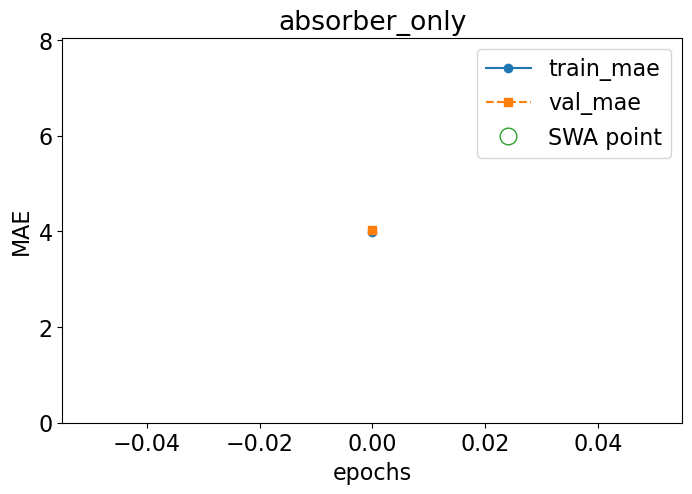

Epoch: 19/300 --- train mae: 2.69 val mae: 3.11


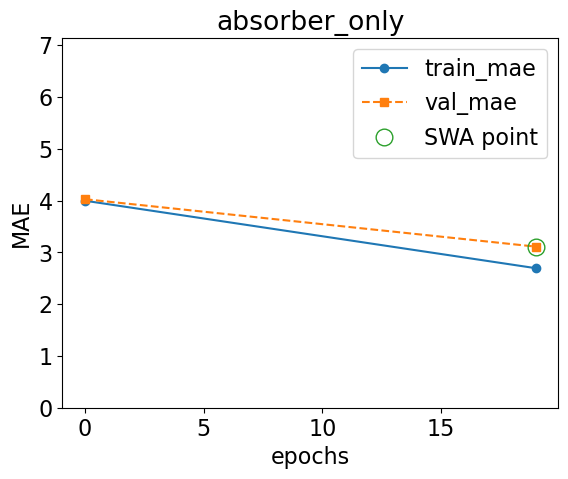

Epoch: 39/300 --- train mae: 2.5 val mae: 3.12


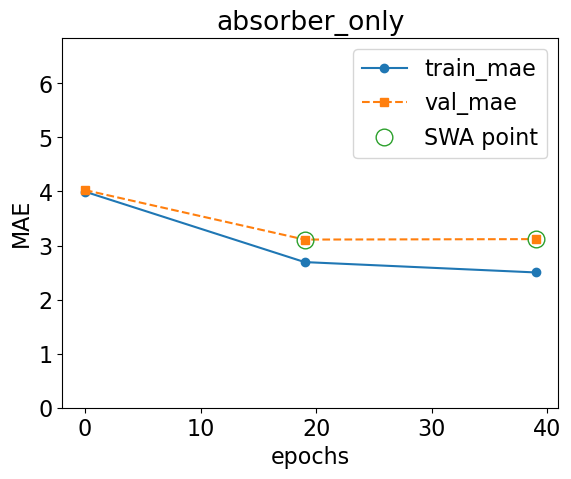

Epoch: 59/300 --- train mae: 2.43 val mae: 3.12


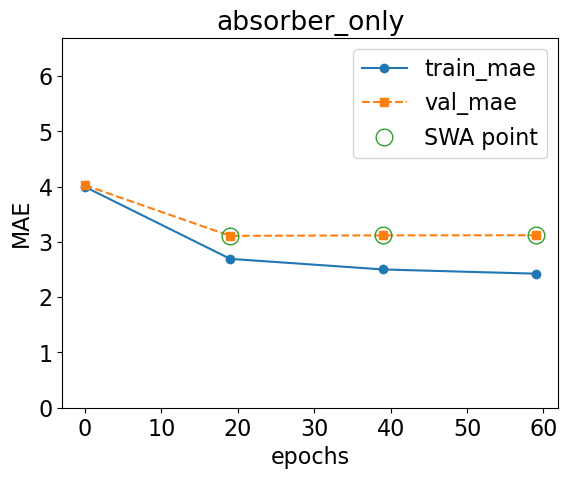

Epoch: 79/300 --- train mae: 2.38 val mae: 3.13


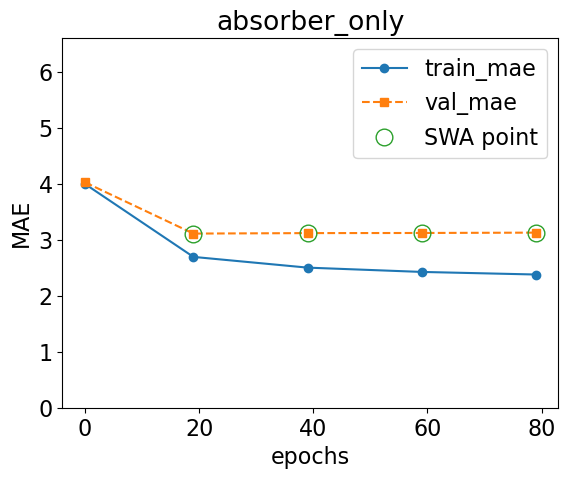

Epoch 99 failed to improve.
Discarded: 1/3 weight updates
Epoch: 99/300 --- train mae: 2.35 val mae: 3.17


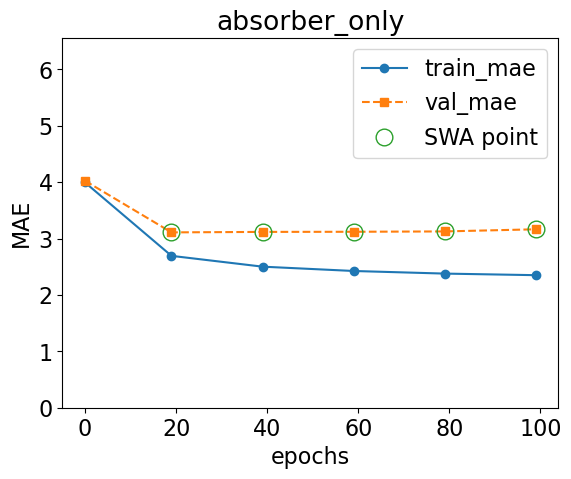

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 2.32 val mae: 3.16


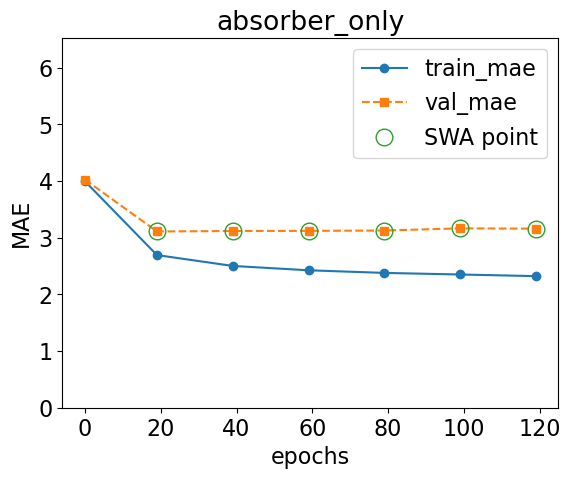

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 2.3 val mae: 3.17


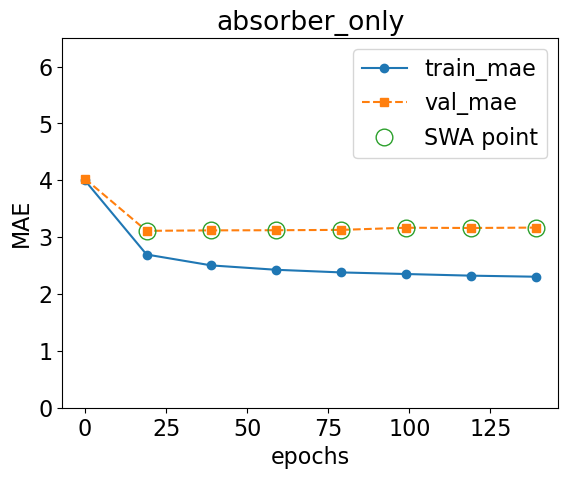

Discarded: 3/3weight updates, early-stopping now
Saving network (absorber_only) to models/trained_models/absorber_only.pth


In [5]:
cb_absorber_only = CrabNet(mat_prop="pce",
                           model_name='absorber_only',
                           elem_prop='mat2vec', 
                           learningcurve=False)
cb_absorber_only.fit(train_df, val_df)

Generating EDM: 100%|██████████| 538/538 [00:00<00:00, 126176.22formulae/s]


loading data with up to 9 elements in the formula


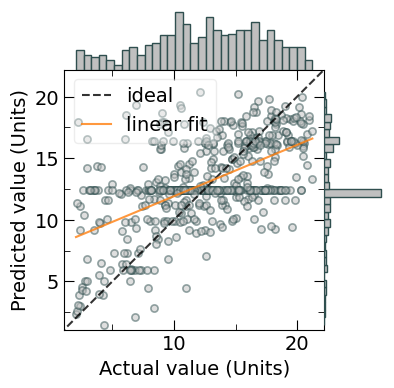

R2 score: 0.2941539754766742
MSE: 15.429690955714575
MAE: 2.9815519399281163


In [12]:
# Predictions
pred_df = test_df

pred_df_zeros = pd.DataFrame(({"formula": pred_df['formula'], "target": [0.0]*len(pred_df['formula'])}))
df_predicted, df_predicted_sigma = cb_absorber_only.predict(pred_df_zeros, return_uncertainty=True)

act_pred(pred_df['target'], df_predicted)
r2 = r2_score(pred_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(pred_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(pred_df['target'], df_predicted)
print(f'MAE: {mae}')

## Absorber + label encoded etl, htl and device stack

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 4301/4301 [00:00<00:00, 100433.71formulae/s]


loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 538/538 [00:00<00:00, 131622.47formulae/s]


loading data with up to 9 elements in the formula
stepping every 170 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 4 val mae: 4.03


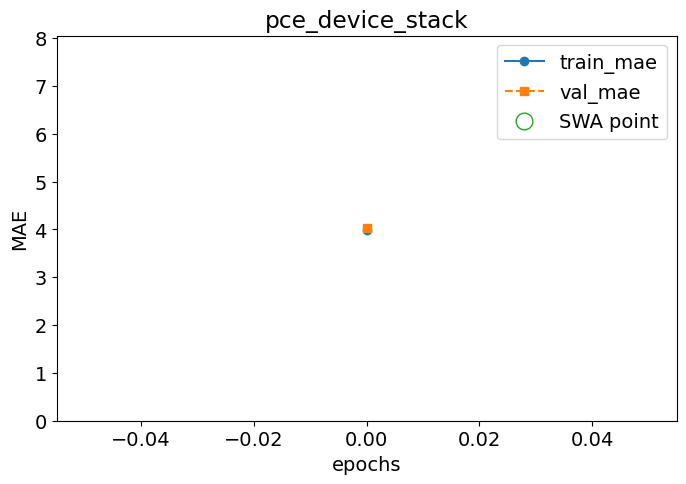

Epoch: 19/300 --- train mae: 2.69 val mae: 3.11


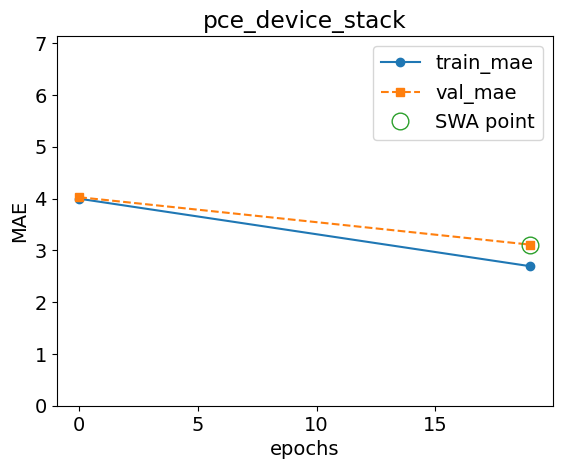

Epoch: 39/300 --- train mae: 2.5 val mae: 3.12


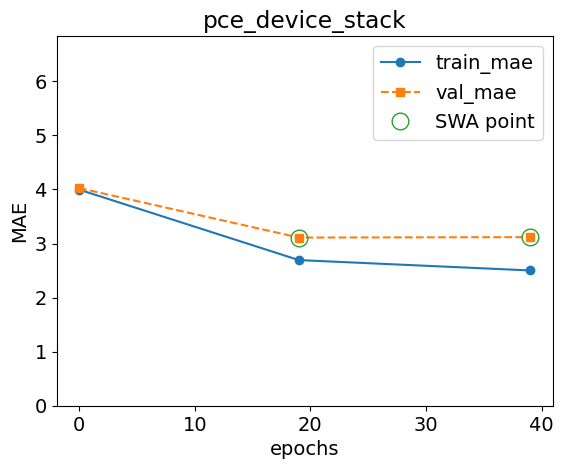

Epoch: 59/300 --- train mae: 2.43 val mae: 3.12


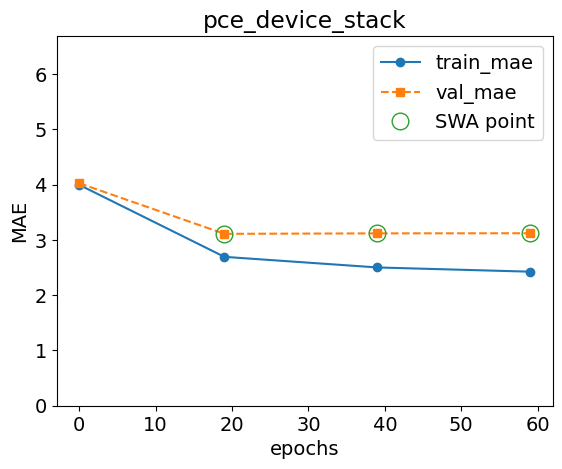

Epoch: 79/300 --- train mae: 2.38 val mae: 3.13


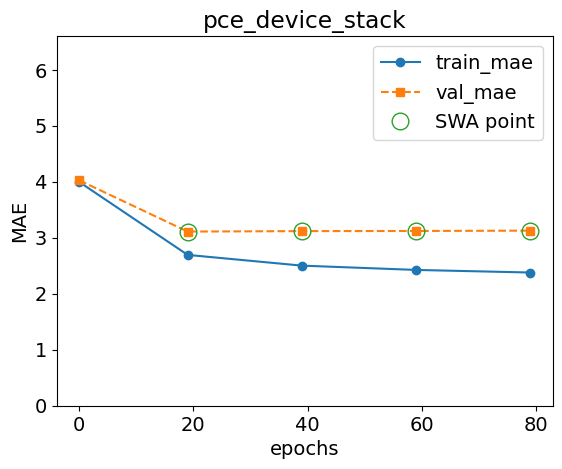

Epoch 99 failed to improve.
Discarded: 1/3 weight updates
Epoch: 99/300 --- train mae: 2.35 val mae: 3.17


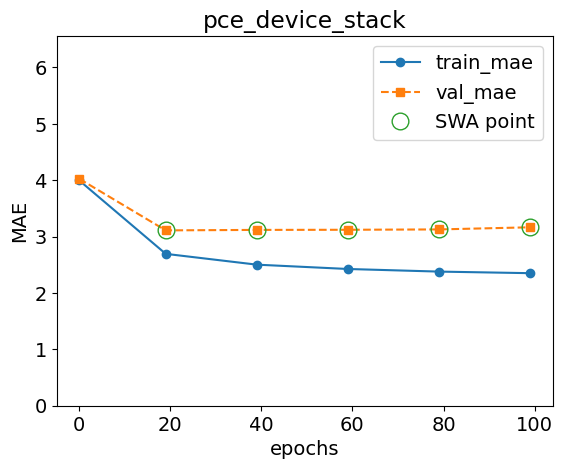

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 2.32 val mae: 3.16


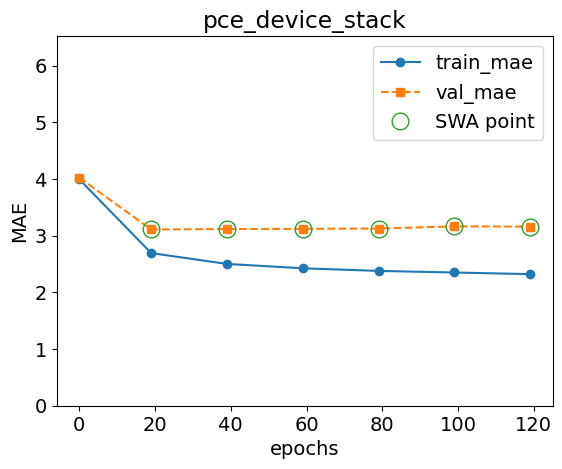

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 2.3 val mae: 3.17


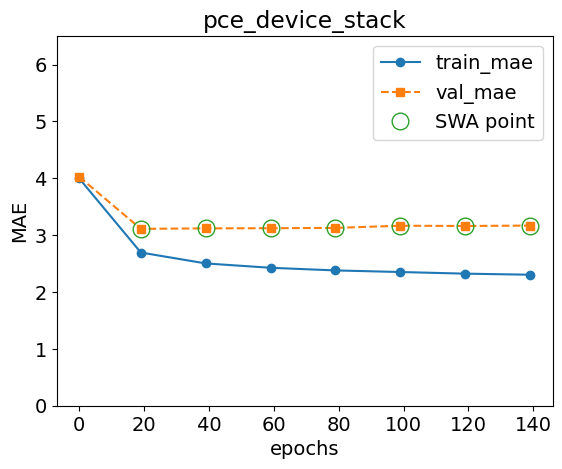

Discarded: 3/3weight updates, early-stopping now
Saving network (pce_device_stack) to models/trained_models/pce_device_stack.pth


In [5]:
cb_labels = CrabNet(mat_prop="pce",
                           model_name='pce_device_stack',
                           elem_prop='mat2vec', 
                           learningcurve=False, 
                           extend_features=['device_stack_encoded', 'etl_encoded', 'htl_encoded'])
cb_labels.fit(train_df, val_df)

Generating EDM: 100%|██████████| 538/538 [00:00<00:00, 131814.68formulae/s]


loading data with up to 9 elements in the formula


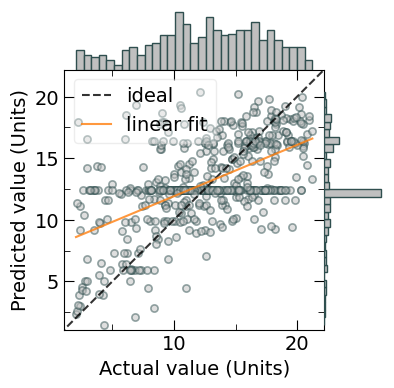

R2 score: 0.2941539754766742
MSE: 15.429690955714575
MAE: 2.9815519399281163


In [7]:
# Predictions
pred_df = test_df

pred_df_zeros = pd.DataFrame(({"formula": pred_df['formula'],
                               "target": [0.0]*len(pred_df['formula']),
                               "device_stack_encoded": pred_df['device_stack_encoded'],
                               "etl_encoded": pred_df['etl_encoded'],
                               "htl_encoded": pred_df['htl_encoded']}))
df_predicted, df_predicted_sigma = cb_labels.predict(pred_df_zeros, return_uncertainty=True)

act_pred(pred_df['target'], df_predicted)
r2 = r2_score(pred_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(pred_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(pred_df['target'], df_predicted)
print(f'MAE: {mae}')

## Absorber and Fingerprints

### Specific data preparation

In [15]:
# load data
# Build a dataframe that contains all predictors and only contains fully identified cells for a start
df = pd.read_csv('data/df_all_cells_many_properties_NORTH.csv')
print(f"Raw data length: {len(df)}.")

# eliminate all cells that have non-identified htls or etls. This pickle
# was created in How_many_cells_identified.ipynb
with open('data/df_all_ctls_identified_v2.pkl', 'rb') as f:
    df_id = pickle.load(f)
print(f"Length of CTL identification info: {len(df_id)}.")

# add the both_identified column to df and only keep the fully identified cells
df['both_identified'] = df_id['both_identified']
df_all_identified = df[df['both_identified'] == True]
print(f"After keeping only fully identified CTLs: {len(df_all_identified)}.")

# drop cells without a device stack information (306)
df_all_identified['device_stack'].apply(ast.literal_eval)
df_all_identified = df_all_identified.dropna(subset=['device_stack'])
print(f"After dropping NAs in device stack: {len(df_all_identified)}.")

# drop cells without reduced_formulas
df_all_identified = df_all_identified[df_all_identified['reduced_formulas'] != "None"]
print(f"After dropping None strings in reduced_formulas: {len(df_all_identified)}.")

df_all_identified = df_all_identified.dropna(subset=['reduced_formulas'])
print(f"After dropping NAs in reduced_formulas: {len(df_all_identified)}.")

# eliminate cells that were measured at an illumination intensity other than 1000 W/m^2
df_all_identified['ill_int'] = pd.to_numeric(df_all_identified['ill_int'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['ill_int'] == 1000]
print(f"After dropping cells that were measured at illumination intensity other than 1000 W/m^2: {len(df_all_identified)}.")

# eliminate rows with large device areas
df_all_identified['device_area'] = pd.to_numeric(df_all_identified['device_area'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['device_area'] <= 0.000025]
print(f"After dropping cells with device area greater than 25 mm^2: {len(df_all_identified)}.")


# drop everything that is not further needed
df_all_identified = df_all_identified.drop(columns=['voc', 
                                                    'jsc', 
                                                    'ff', 
                                                    'structural_dimensionality', 
                                                    'both_identified', 
                                                    'device_stack',
                                                    'ill_int',
                                                    'device_area',
                                                   ])

# transform etl and htl to lists
df_all_identified['etl'] = df_all_identified['etl'].apply(ast.literal_eval)
df_all_identified['htl'] = df_all_identified['htl'].apply(ast.literal_eval)


# split entries separated with semicolons into proper comma separated lists
for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "etl"]):
        if ";" in df_all_identified.at[index, "etl"][i]:
            elements = df_all_identified.at[index, "etl"][i].split(";")
            df_all_identified.at[index, "etl"] = df_all_identified.at[index, "etl"][:i] + elements + df_all_identified.at[index, "etl"][i+1:]
        i += 1

for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "htl"]):
        if ";" in df_all_identified.at[index, "htl"][i]:
            elements = df_all_identified.at[index, "htl"][i].split(";")
            df_all_identified.at[index, "htl"] = df_all_identified.at[index, "htl"][:i] + elements + df_all_identified.at[index, "htl"][i+1:]
        i += 1
        
# transform pce to numeric
df_all_identified['pce'] = pd.to_numeric(df_all_identified['pce'], errors='coerce')
df_all_identified = df_all_identified.dropna(subset=['pce'])
print(f"After dropping cells without pce information: {len(df_all_identified)}.")

# transform bandgaps to proper size values, transforming nones into zeros
df_all_identified['bandgap'] = pd.to_numeric(df_all_identified['bandgap'], errors='coerce')
# check how many bandgaps are none
df_check = df_all_identified.dropna(subset=['bandgap'])
print(f"How many nones in bandgap: {len(df_all_identified)-len(df_check)}")
df_all_identified['bandgap'] = df_all_identified['bandgap'].fillna(0)
df_all_identified['bandgap'] = df_all_identified['bandgap']*6.24150974e18

df_all_identified['etl_key'] = df_all_identified['etl'].apply(lambda x: ';'.join(x))
df_all_identified['htl_key'] = df_all_identified['htl'].apply(lambda x: ';'.join(x))
df_all_identified['bandgap_key'] = df_all_identified['bandgap'].round(decimals=4)

df_all_identified = df_all_identified.groupby(['reduced_formulas', 'etl_key', 'htl_key', 'bandgap_key']).agg({
                       'reduced_formulas': 'first',
                       'etl': 'first',
                       'htl': 'first',
                       'bandgap': 'mean',
                       # 'device_stack': 'first',
                       'pce': 'mean',
                      }).reset_index(drop=True)

Raw data length: 43108.
Length of CTL identification info: 43108.
After keeping only fully identified CTLs: 37633.
After dropping NAs in device stack: 37633.
After dropping None strings in reduced_formulas: 37081.
After dropping NAs in reduced_formulas: 37081.
After dropping cells that were measured at illumination intensity other than 1000 W/m^2: 36662.
After dropping cells with device area greater than 25 mm^2: 34005.
After dropping cells without pce information: 33286.
How many nones in bandgap: 7875


In [16]:
try:
    with open('data/larger_SMILES_dict.pkl', 'rb') as f:
        larger_SMILES_dict = pickle.load(f)
except:
    with open('data/dict_device_stack_materials.pkl', 'rb') as f:
        ds_dict = pickle.load(f)
    
    def CID_to_SMILES(CID):
        '''
        This searches for a CTL material's CID in PubChem.
        Argument: industry_name (str) - the name of the material
        Value: CID (int) - the CID of the material
        '''
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{CID}/property/CanonicalSMILES/JSON"
        
        response = requests.get(url)
    
        if response.status_code == 200:
            data = response.json()
            data = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
            return data
        else:
            print('debug: SMILES could not be retrieved')
            raise Exception(f"Error: Could not retrieve SMILES from this CID. Status code: {response.status_code}")
            return None
    
    #initialize new dictionary where the SMILES will be written
    larger_SMILES_dict = {}
    
    # populate the SMILES dictionary
    for index, name in enumerate(ds_dict):
        print(f"{index+1}/2559. Next up: {name}")
        CID = ds_dict[name]
        if CID is not None:
            SMILES = CID_to_SMILES(CID)
            larger_SMILES_dict[name] = SMILES
        else:
            larger_SMILES_dict[name] = None
    
    with open('data/larger_SMILES_dict.pkl', 'wb') as f:
        pickle.dump(larger_SMILES_dict, f)

In [17]:
# Write SMILES into the dataframe
df_all_identified['pce'] = df_all_identified['pce'].astype(float)

# the SMILES_dict contains no entry for "no ctl" yet
larger_SMILES_dict['none'] = "no_ctl"

for index, row in df_all_identified.iterrows():
    etl_SMILES = []
    for element in row['etl']:
        etl_SMILES.append(larger_SMILES_dict[element])
    df_all_identified.loc[index, 'etl_SMILES'] = str(etl_SMILES)
    htl_SMILES = []
    for element in row['htl']:
        htl_SMILES.append(larger_SMILES_dict[element])
    df_all_identified.loc[index, 'htl_SMILES'] = str(htl_SMILES)

# output of the function are strings, so we transform to lists
df_all_identified['etl_SMILES'] = df_all_identified['etl_SMILES'].apply(ast.literal_eval)
df_all_identified['htl_SMILES'] = df_all_identified['htl_SMILES'].apply(ast.literal_eval)

# drop rows where the etl_SMILES or the htl_SMILES contain None
def has_all_non_none_elements(data_list):
  """Checks if all elements in a list are not None."""
  return all(element is not None for element in data_list)

# Filter rows where any element in etl_SMILES or htl_SMILES is None
print(len(df_all_identified))
df_all_identified = df_all_identified[df_all_identified['etl_SMILES'].apply(has_all_non_none_elements) &
                                 df_all_identified['htl_SMILES'].apply(has_all_non_none_elements)]
print(len(df_all_identified))

5822
5818


In [18]:
etl_combined_SMILES = []
htl_combined_SMILES = []

for index, row in df_all_identified.iterrows():
    etl_combination = ".".join(row['etl_SMILES'])
    htl_combination = ".".join(row['htl_SMILES'])
    etl_combined_SMILES.append(etl_combination)
    htl_combined_SMILES.append(htl_combination)
df_all_identified['etl_combined_SMILES'] = etl_combined_SMILES
df_all_identified['htl_combined_SMILES'] = htl_combined_SMILES

df_all_identified['etl_combined_SMILES'] = df_all_identified['etl_combined_SMILES'].str.replace('no_ctl', '')
df_all_identified['htl_combined_SMILES'] = df_all_identified['htl_combined_SMILES'].str.replace('no_ctl', '')

fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

def smiles_to_fingerprint(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return np.zeros(fpgen.GetNumBits(),)
    fp = fpgen.GetFingerprint(molecule)
    # Convert to a bit vector
    bit_vector = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, bit_vector)
    return bit_vector

# Create columns for Morgan Fingerprints
etl_fingerprints = df_all_identified['etl_combined_SMILES'].apply(smiles_to_fingerprint)
htl_fingerprints = df_all_identified['htl_combined_SMILES'].apply(smiles_to_fingerprint)

# Convert fingerprints to DataFrame
etl_fingerprint_df = pd.DataFrame(etl_fingerprints.tolist(), columns=[f'ETL_FP_{i}' for i in range(1024)])
htl_fingerprint_df = pd.DataFrame(htl_fingerprints.tolist(), columns=[f'HTL_FP_{i}' for i in range(1024)])

# Combine all features into a single DataFrame
features_df = pd.DataFrame
features_df = pd.concat([df_all_identified.drop(columns=['etl', 
                                                         'htl', 
                                                         'etl_SMILES',
                                                         'htl_SMILES',
                                                         'etl_combined_SMILES',
                                                         'htl_combined_SMILES']), etl_fingerprint_df, htl_fingerprint_df], axis=1)

print(len(features_df))
features_df = features_df.dropna()
print(len(features_df))

features_df

[15:42:04] WARNING: not removing hydrogen atom without neighbors
[15:42:21] WARNING: not removing hydrogen atom without neighbors
[15:42:21] WARNING: not removing hydrogen atom without neighbors


5822
5814


,reduced_formulas,bandgap,pce,ETL_FP_0,ETL_FP_1,ETL_FP_2,ETL_FP_3,ETL_FP_4,ETL_FP_5,ETL_FP_6,...,HTL_FP_1014,HTL_FP_1015,HTL_FP_1016,HTL_FP_1017,HTL_FP_1018,HTL_FP_1019,HTL_FP_1020,HTL_FP_1021,HTL_FP_1022,HTL_FP_1023
0,Ag10Bi10Br57Cs20,0.00,1.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ag10Bi10Br59Cs20,0.00,1.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ag10Bi10Br60Cs17Rb3,0.00,0.850000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ag10Bi10Br60Cs19Rb,0.00,1.270000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ag20Bi20CsI60,1.86,3.530000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5813,CsI6RbSn2,0.00,1.810000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5814,CsI6RbSn2,0.00,0.646667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5815,H12I9N3Sb2,2.27,0.277273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5816,I3PbRb,1.98,1.030000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
features_df.rename(columns={'pce': 'target'}, inplace=True)
features_df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

In [30]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
fp_train_df, fp_val_df, fp_test_df = \
              np.split(features_df.sample(frac=1,
                                          random_state=42), 
                       [int(.8*len(features_df)),
                        int(.9*len(features_df))])

### CrabNet Training


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Generating EDM: 100%|██████████| 4651/4651 [00:00<00:00, 92314.03formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 581/581 [00:00<00:00, 121838.44formulae/s]


loading data with up to 8 elements in the formula
stepping every 190 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 4.69 val mae: 4.76


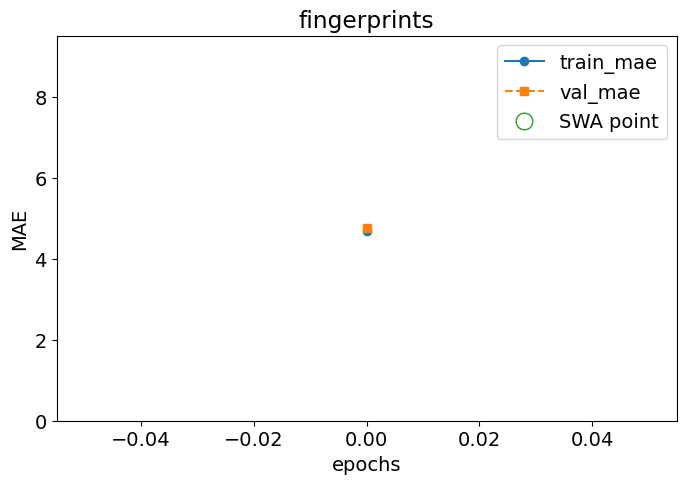

Epoch: 19/300 --- train mae: 2.84 val mae: 3.25


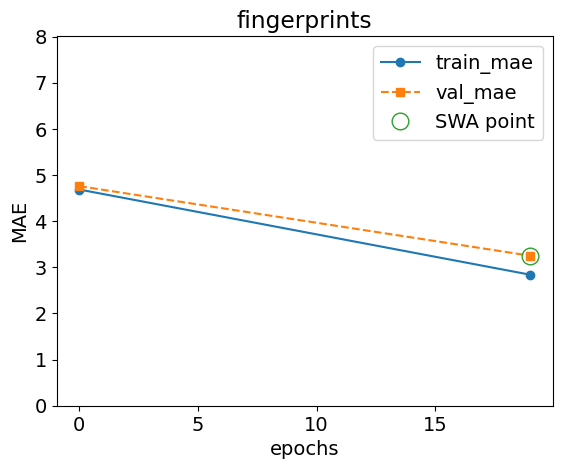

Epoch: 39/300 --- train mae: 2.65 val mae: 3.22


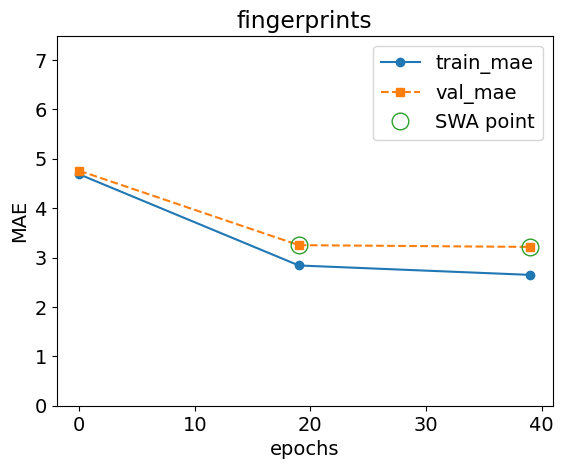

Epoch: 59/300 --- train mae: 2.55 val mae: 3.22


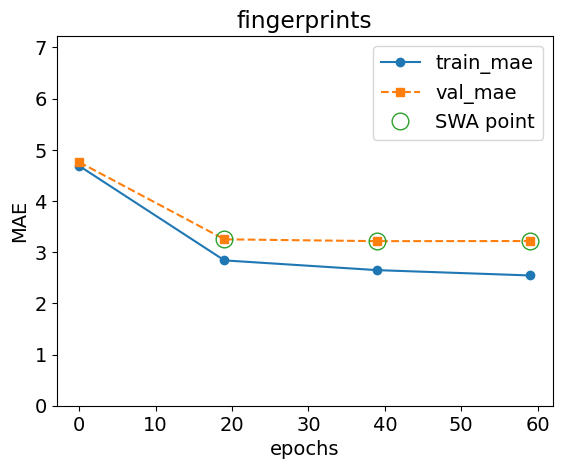

Epoch: 79/300 --- train mae: 2.48 val mae: 3.24


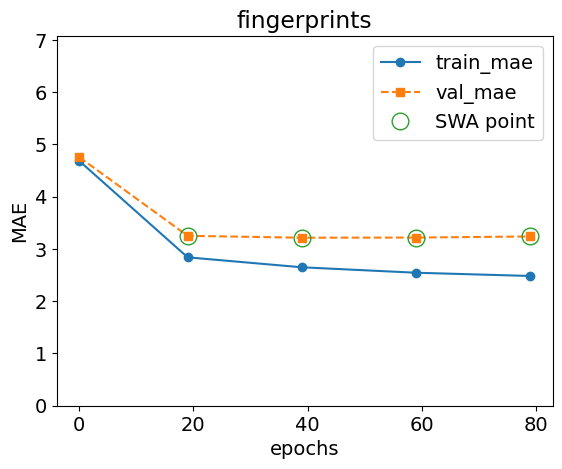

Epoch: 99/300 --- train mae: 2.45 val mae: 3.24


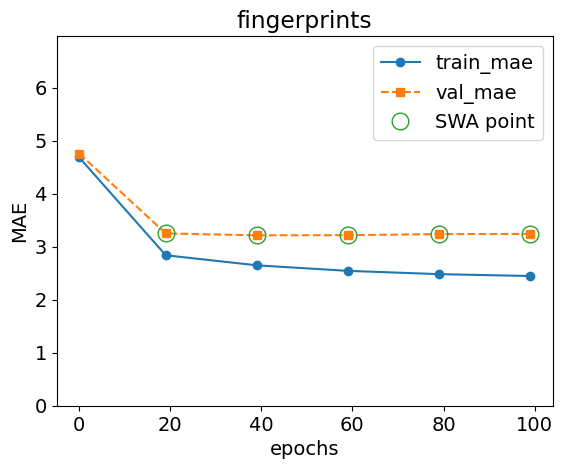

Epoch: 119/300 --- train mae: 2.42 val mae: 3.24


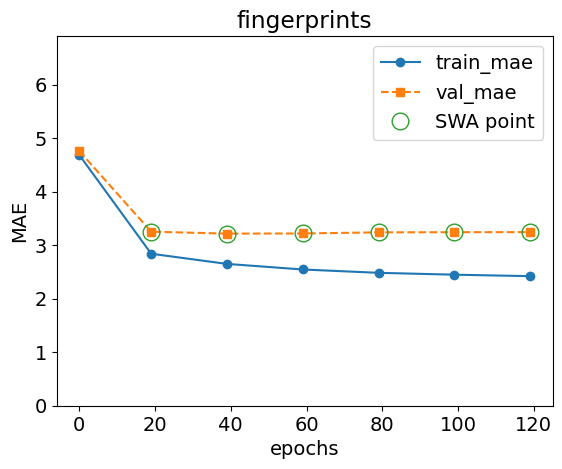

Epoch 139 failed to improve.
Discarded: 1/3 weight updates
Epoch: 139/300 --- train mae: 2.4 val mae: 3.3


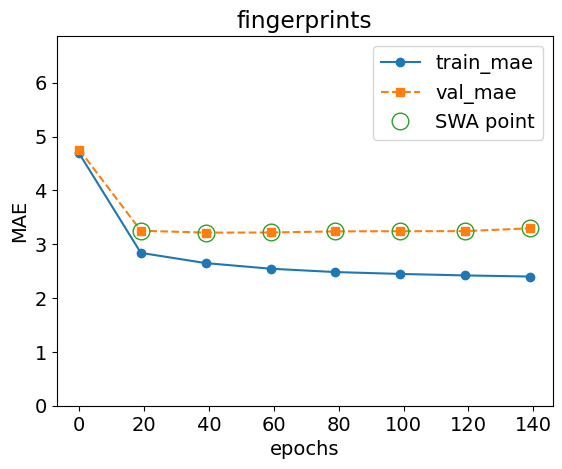

Epoch 159 failed to improve.
Discarded: 2/3 weight updates
Epoch: 159/300 --- train mae: 2.39 val mae: 3.3


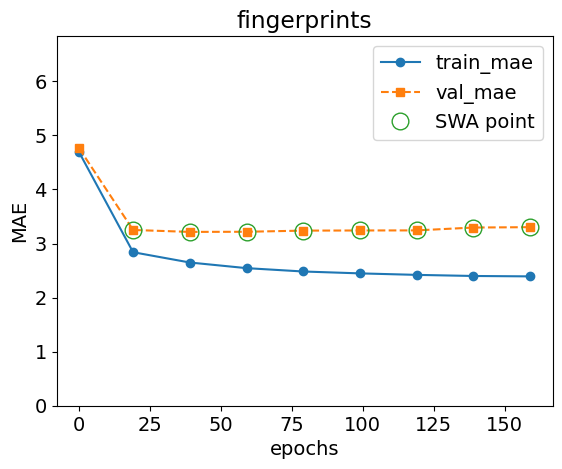

Epoch 179 failed to improve.
Discarded: 3/3 weight updates
Epoch: 179/300 --- train mae: 2.38 val mae: 3.25


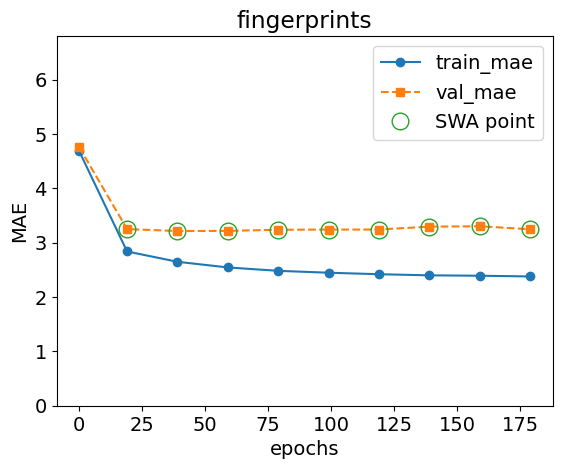

Discarded: 3/3weight updates, early-stopping now
Saving network (fingerprints) to models/trained_models/fingerprints.pth


In [9]:
fingerprints = list(features_df.columns[3:2052])

cb_fingerprints = CrabNet(mat_prop="pce",
                          model_name='fingerprints',
                          elem_prop='mat2vec', 
                          learningcurve=False, 
                          extend_features=fingerprints)
cb_fingerprints.fit(fp_train_df, fp_val_df)

Generating EDM: 100%|██████████| 582/582 [00:00<00:00, 125434.71formulae/s]


loading data with up to 8 elements in the formula


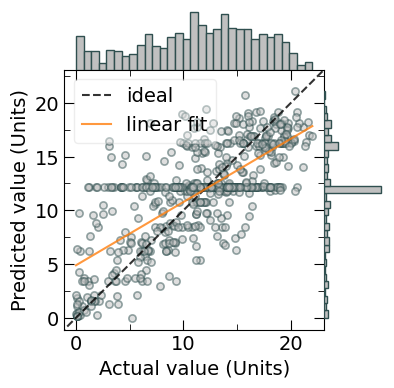

R2 score: 0.5127380206082832
MSE: 14.47410389551568
MAE: 2.9247436010735615


In [31]:
# Predictions
pred_df = fp_test_df.copy()
pred_df_zeros = pred_df.copy()

pred_df_zeros['target'] = [0.0]*len(pred_df['formula'])

df_predicted, df_predicted_sigma = cb_fingerprints.predict(pred_df_zeros, return_uncertainty=True)

act_pred(pred_df['target'], df_predicted)
r2 = r2_score(pred_df['target'], df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(pred_df['target'], df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(pred_df['target'], df_predicted)
print(f'MAE: {mae}')